# Введение в искусственные нейронные сети
# Урок 6. Сегментация

## Домашнее задание

1. Попробуйте обучить нейронную сеть U-Net на любом другом датасете. Можете взять один из этих наборов данных:
    - https://www.kaggle.com/carlolepelaars/camvid
    - https://www.kaggle.com/dansbecker/cityscapes-image-pairs
    - https://www.kaggle.com/tapakah68/segmentation-full-body-mads-dataset
    - https://www.kaggle.com/longnguyen2306/bacteria-detection-with-darkfield-microscopy
    - https://www.kaggle.com/nikhilpandey360/chest-xray-masks-and-labels
2. Опишите в комментарии - какого результата вы добились от нейросети? Что помогло вам улучшить ее точность?

### 1. Импорты

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from tensorflow.keras.utils import load_img, array_to_img, img_to_array, plot_model
from keras.models import Sequential, Model
from keras.layers import Activation, Input, MaxPooling2D, BatchNormalization, Conv2D, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output
import os
import cv2
import zipfile
import keras.backend as K


### 2. Загрузка и подготовка данных

In [2]:
!wget 'https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1rTVZBvz0CJaQZMURiFBZ0HCFRhmNTFrm' -O segment.zip

--2022-11-05 17:08:16--  https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1rTVZBvz0CJaQZMURiFBZ0HCFRhmNTFrm
Resolving drive.google.com (drive.google.com)... 142.251.12.113, 142.251.12.100, 142.251.12.102, ...
Connecting to drive.google.com (drive.google.com)|142.251.12.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-5g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/bjg0keo8g4u691aogm1a4iv47sbtsqc7/1667668050000/13435738219262891387/*/1rTVZBvz0CJaQZMURiFBZ0HCFRhmNTFrm?e=download&uuid=9106b10a-80da-418f-a802-7b69526f143d [following]
--2022-11-05 17:08:17--  https://doc-0o-5g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/bjg0keo8g4u691aogm1a4iv47sbtsqc7/1667668050000/13435738219262891387/*/1rTVZBvz0CJaQZMURiFBZ0HCFRhmNTFrm?e=download&uuid=9106b10a-80da-418f-a802-7b69526f143d
Resolving doc-0o-5g-docs.googleusercontent.com (doc-0o-5g-docs.googleusercontent.com)... 

In [3]:
with zipfile.ZipFile('/content/segment.zip') as zf:
  zf.extractall()

In [4]:
imgs_dir = '/content/segmentation_full_body_mads_dataset_1192_img/images'
masks_dir = '/content/segmentation_full_body_mads_dataset_1192_img/masks'

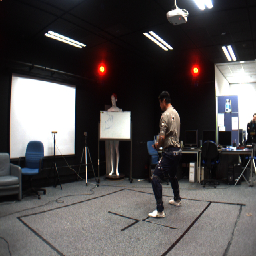

In [5]:
load_img(os.path.join(imgs_dir, os.listdir(imgs_dir)[5]), target_size = (256, 256, 3))

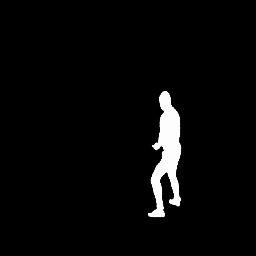

In [6]:
load_img(os.path.join(masks_dir, os.listdir(masks_dir)[5]), target_size = (256, 256, 1))

Теперь сложу картинки и маски в массивы

In [7]:
imgs_arr = np.zeros((len(os.listdir(imgs_dir)), 256, 256, 3), dtype = float)
masks_arr = np.zeros((len(os.listdir(masks_dir)), 256, 256, 1), dtype = bool)

In [8]:
for index in range(len(os.listdir(imgs_dir))):
    img = load_img(os.path.join(imgs_dir, os.listdir(imgs_dir)[index]), target_size = (256, 256, 3))
    imgs_arr[index] = img_to_array(img)

In [9]:
for index in range(len(os.listdir(masks_dir))):
    img = load_img(os.path.join(masks_dir, os.listdir(masks_dir)[index]), target_size = (256, 256, 1), color_mode="grayscale" )
    masks_arr[index] = img_to_array(img)

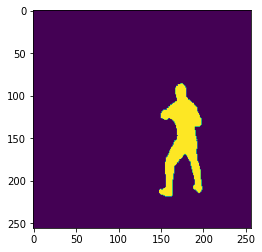

In [10]:
plt.imshow(masks_arr[69].squeeze());

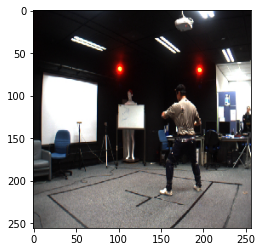

In [11]:
plt.imshow(array_to_img(imgs_arr[69].squeeze()))

In [12]:
test_size = 0.3
X_train, X_test = imgs_arr[:int(len(imgs_arr) * (1 - test_size))], imgs_arr[int(len(imgs_arr) * (1 - test_size)):]
y_train, y_test = masks_arr[:int(len(masks_arr) * (1 - test_size))], masks_arr[int(len(masks_arr) * (1 - test_size)):]

### 3. Подготовка и обучение модели

Будем смотреть метрику DICE, ее надо написать

In [13]:
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1) / (K.sum(y_true) + K.sum(y_pred) + 1)

Теперь сама модель. Обучать буду UNET из 3 сжимающих блоков (конволюции + макспулинг + нормализация) и 3 разжимающих блоков (обратные конволюции + конволюции). Выход каждого сжимающего блока буду пробрасывать в соответствующий разжимающий. На выходе сделаю слой классификатор - конволюцию с активацией sigmoid.

In [19]:
img_input = Input((256, 256, 3))

# Block 1
x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
x = BatchNormalization()(x)

# запомним тензор для переноса
block_1_out = Activation('relu')(x)

x = MaxPooling2D()(block_1_out)


# Block 2
x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
x = BatchNormalization()(x)

# запомним тензор для переноса
block_2_out = Activation('relu')(x)

x = MaxPooling2D()(block_2_out)


# Block 3
x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
x = BatchNormalization()(x)

# запомним тензор для переноса
block_3_out = Activation('relu')(x)

x = MaxPooling2D()(block_3_out)


# Block 4
x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
x = BatchNormalization()(x)

# запомним тензор для переноса
block_4_out = Activation('relu')(x)


# UP 1
x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = concatenate([x, block_3_out])
x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# UP 2
x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = concatenate([x, block_2_out])
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# UP 3
x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = concatenate([x, block_1_out])
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)


# слой классификатор
x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

model = Model(img_input, x)

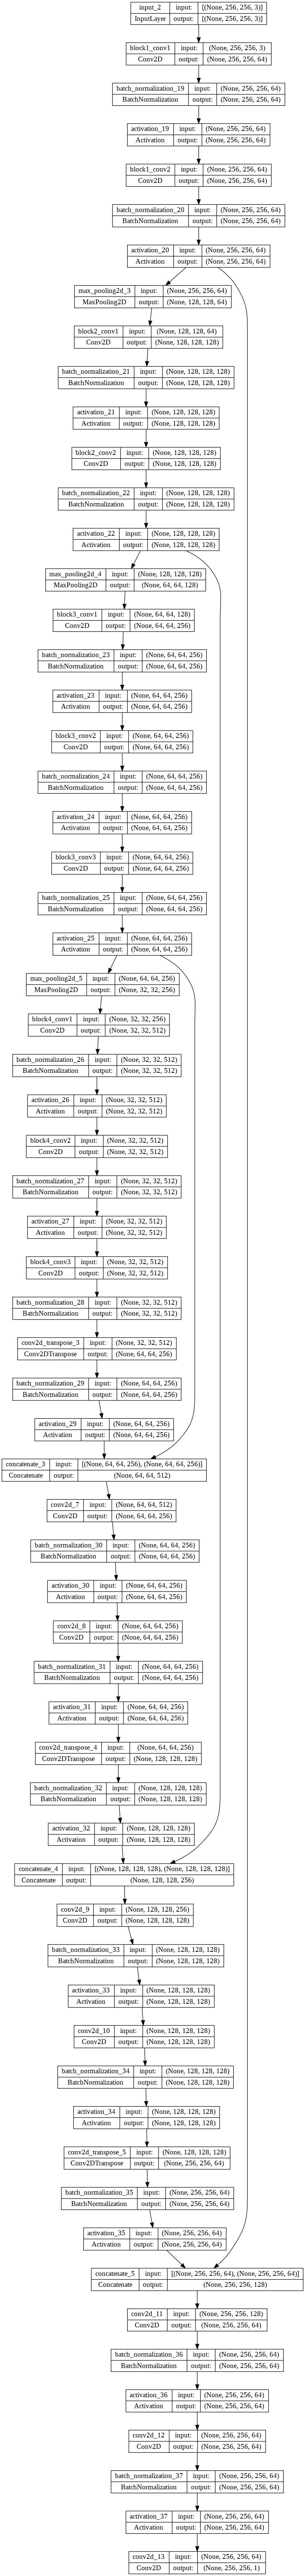

In [20]:
plot_model(model, show_shapes=True)

In [21]:
model.compile(optimizer=Adam(),
                loss='binary_crossentropy',
                metrics=[dice_coef])

In [22]:
model.fit(X_train, y_train, epochs=10, batch_size=8, validation_data=(X_test, y_test))

Epoch 1/10
105/105 [==============================] - 60s 551ms/step - loss: 0.0739 - dice_coef: 0.6822 - val_loss: 0.2813 - val_dice_coef: 0.3587
Epoch 2/10
105/105 [==============================] - 60s 569ms/step - loss: 0.0381 - dice_coef: 0.8279 - val_loss: 0.0697 - val_dice_coef: 0.7327
Epoch 3/10
105/105 [==============================] - 57s 541ms/step - loss: 0.0303 - dice_coef: 0.8885 - val_loss: 0.0359 - val_dice_coef: 0.8282
Epoch 4/10
105/105 [==============================] - 57s 540ms/step - loss: 0.0303 - dice_coef: 0.8836 - val_loss: 0.0515 - val_dice_coef: 0.7832
Epoch 5/10
105/105 [==============================] - 57s 539ms/step - loss: 0.0281 - dice_coef: 0.8971 - val_loss: 0.0387 - val_dice_coef: 0.8496
Epoch 6/10
105/105 [==============================] - 57s 540ms/step - loss: 0.0273 - dice_coef: 0.9019 - val_loss: 0.0326 - val_dice_coef: 0.8733
Epoch 7/10
105/105 [==============================] - 57s 541ms/step - loss: 0.0266 - dice_coef: 0.9059 - val_loss: 0.

### 4. Визуализация работы модели

Исходное изображение

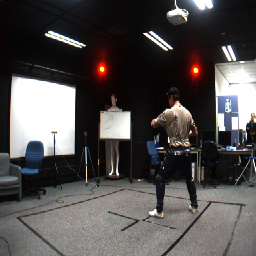

In [23]:
array_to_img(imgs_arr[69])

Предсказанная маска

1/1 [==============================] - 0s 19ms/step


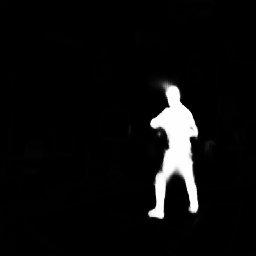

In [25]:
array_to_img(model.predict(imgs_arr[69].reshape((1, 256, 256,3))).reshape((256, 256, 1)))

Истинная маска

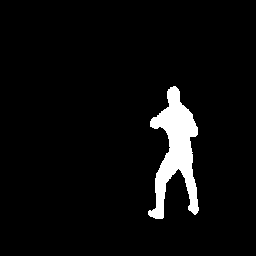

In [26]:
array_to_img(masks_arr[69])

### 5. Выводы и комментарии

1. Самое важное и интересное - я столкнулся со странной работой UNET. В моём понимании, когда я пробрасывал output сжимающих слоёв в input разжимающих, я уточнял границы маски. В результатах (4 раздел) видно, что границы нечёткие. Возможно, требуется больше эпох, но модель и так обучается очень долго.
2. На слое классификации можно делать конволюцию с окном (1, 1), причем качество предсказания не ухудшится.
3. Нормализация картинки на input слое ничего не даёт в плане качества.
4. При размере батча больше 16 колаб выбрасывает исключение ResourceExhaustedError. 